In [11]:
import xarray as xr
import numpy as np
import os
import pandas as pd
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

ANG_HF_PD=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Processed/ANG_550_865_Hifreq_PPE.nc').ANG_550nm_865nm#[0]
AOD_HF_PD=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Processed/AOD_Hifreq_PPE.nc').TAU_2D_550nm#[0]
SSA_HF_PD=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Processed/SSA_Hifreq_PPE.nc').__xarray_dataarray_variable__#[0]


lats=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/AOD_PPE.nc').lat
lons=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/AOD_PPE.nc').lon


In [12]:
# Function to extract date from filename
def extract_date(file_path):
    # Assuming date format is in 'YYYYMMDD' as 'SRON-POLDER-L2-YYYYMMDD-LAND'
    filename = os.path.basename(file_path)
    date_str = filename.split('-')[3]  # Extracts the 'YYYYMMDD' part
    return date_str
def convert_julday_to_hours(file):
    #date=xr.open_dataset(file).julday.load()
    # Extract the fractional part of the day
    fractional_part = file - file.astype(int)
    # Convert to hours
    hours = fractional_part * 24
    julday_with_hours = hours.assign_coords(hours=hours)

    return julday_with_hours
    
def create_datetime_xarray(months, days, hours, reference_time):
    """
    Converts month, day, and hour arrays into a datetime xarray.DataArray 
    mapped to a reference time array.
    
    Parameters:
    - months: Array of month values (1-12).
    - days: Array of day values (1-31).
    - hours: Array of hour values (0.0-24.0).
    - reference_time: Reference xarray.DataArray with datetime64[ns] values.
    
    Returns:
    - datetime_xr: xarray.DataArray of datetimes corresponding to the input.
    """
    # Generate a meshgrid of months, days, and hours for combinations
    months, days, hours = np.meshgrid(months, days, hours, indexing="ij")
    
    # Combine the components into a pandas datetime object
    datetimes = pd.to_datetime({
        "year": reference_time.dt.year.values[0],
        "month": months.flatten(),
        "day": days.flatten(),
        "hour": hours.flatten().astype(int),
        "minute": ((hours.flatten() % 1) * 60).astype(int)
    }, errors='coerce')  # coerce invalid dates into NaT

    # Reshape into the original dimensions
    datetimes = datetimes.values.reshape(months.shape)
    
    # Create an xarray.DataArray
    datetime_xr = xr.DataArray(
        datetimes,
        dims=("month", "day", "hour"),
        coords={"month": np.unique(months), "day": np.unique(days), "hour": np.unique(hours)}
    )

    return datetime_xr
def find_nearest(array, value): # GPT
    return np.abs(array - value).argmin()
# def find_nearest(array, value): ### MINE 
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return array[idx]

def POLDER_Ensemble(MODEL_Overpass,POLDER_variable_Data):
    reference_time = xr.DataArray(
        pd.date_range("2010-01-01", "2010-12-31", freq="6H"),
        dims="time",
        name="time"
    )
    
    combined = xr.concat(MODEL_Overpass, dim="overpass").sortby('ensemble')
    dataset0 = xr.DataArray(
    POLDER_variable_Data[i],    dims=["overpass"],
        coords={"overpass": np.arange(len(MODEL_Overpass))}  # Adjust the length to match "overpass"
    )
    # Create a new ensemble coordinate for dataset0
    new_ensemble_id = -1  # New ensemble identifier
    
    # Align dataset0 to the overpass dimension
    dataset0_aligned = xr.DataArray(
        dataset0.values,  # Values from dataset0
        dims=["overpass"],  # Use the existing overpass dimension
        coords={"overpass": combined["overpass"]}  # Align with the original overpass
    )
    
    # Add the ensemble dimension and coordinate to dataset0_aligned
    dataset0_expanded = dataset0_aligned.expand_dims("ensemble")
    dataset0_expanded["ensemble"] = [new_ensemble_id]  # Assign the new ensemble coordinate
    
    # Concatenate the updated dataset along the ensemble dimension
    updated_data = xr.concat([combined, dataset0_expanded], dim="ensemble")
    return updated_data


import xarray as xr
import numpy as np

def process_POLDER_data(input_data):
    """
    Processes the input climate data by:
    - Flattening overpass and day dimensions.
    - Grouping data by month.
    - Regridding to a common latitude/longitude grid.
    - Combining monthly data into a single DataArray.
    
    Parameters:
    input_data (xarray.DataArray): Input data with dimensions (day, overpass, ensemble)
    
    Returns:
    xarray.DataArray: Regridded and combined data along the 'month' dimension.
    """
    # Exclude the last ensemble member if needed
    
    # Flatten the overpass dimension
    da_flat = input_data.stack(sample=("day", "overpass"))
    
    # Drop NaT values in time
    da_flat = da_flat.sel(sample=~xr.ufuncs.isnan(da_flat["time"]))
    
    # Group by month
    grouped_da = da_flat.groupby(da_flat["time"].dt.month)
    
    # Initialize a list to store monthly data
    monthly_data = []
    
    # Loop through months 1 to 12
    for month in range(1, 13):
        # Select data for the current month
        monthly_da = grouped_da[month]
        
        # Extract the month from the 'time' coordinate
        monthly_da['month'] = monthly_da['time'].dt.month
        
        # Group by 'lat' and 'lon' and compute the mean
        grouped = monthly_da.groupby(['lat', 'lon']).mean()
        try:
            # Unstack the grouped data to restore 'lat' and 'lon' as dimensions
            grouped = grouped.unstack('sample')
        except:
            pass
        
        # Store the reshaped data
        monthly_data.append(grouped)
    
    # Step 1: Find the global min/max latitudes and longitudes
    all_lats = np.concatenate([data.lat.values for data in monthly_data if 'lat' in data.dims])
    all_lons = np.concatenate([data.lon.values for data in monthly_data if 'lon' in data.dims])

    min_lat, max_lat = np.nanmin(all_lats), np.nanmax(all_lats)
    min_lon, max_lon = np.nanmin(all_lons), np.nanmax(all_lons)

    # Step 2: Create a new common lat/lon grid covering all the data
    new_lats = np.arange(min_lat, max_lat, 1)  # Adjust the step size as needed
    new_lons = np.arange(min_lon, max_lon, 1)  # Adjust the step size as needed

    # Step 3: Regrid each month's data to this new grid
    aligned_data = []
    for data in monthly_data:
        # Ensure the DataArray has 'lat' and 'lon' dimensions
        if 'lat' in data.dims and 'lon' in data.dims:
            aligned_data.append(data.interp(lat=new_lats, lon=new_lons))

    # Step 4: Combine all the months into a single DataArray along the 'month' dimension
    combined_data = xr.concat(aligned_data, dim='month')
    
    return combined_data

import numpy as np
import xarray as xr

def regrid_and_combine(land_data, ocean_data, step_size=1):
    """
    Regrids and combines land and ocean datasets onto a unified latitude-longitude grid.

    Parameters:
    land_data (xarray.DataArray): Land dataset to regrid.
    ocean_data (xarray.DataArray): Ocean dataset to regrid.
    step_size (float): Step size for the new latitude and longitude grid (default is 1).

    Returns:
    xarray.DataArray: Combined regridded and merged land and ocean data.
    """
    # Step 1: Create a new combined grid (union of latitudes and longitudes)
    all_lats = np.concatenate([land_data.lat.values, ocean_data.lat.values])
    all_lons = np.concatenate([land_data.lon.values, ocean_data.lon.values])

    min_lat, max_lat = np.min(all_lats), np.max(all_lats)
    min_lon, max_lon = np.min(all_lons), np.max(all_lons)

    # Create new lat/lon grid
    new_lats = np.arange(min_lat, max_lat, step_size)  # Adjust step size as needed
    new_lons = np.arange(min_lon, max_lon, step_size)  # Adjust step size as needed

    # Step 2: Regrid both datasets onto the new grid
    land_aligned = land_data.interp(lat=new_lats, lon=new_lons)
    ocean_aligned = ocean_data.interp(lat=new_lats, lon=new_lons)

    # Step 3: Initialize the combined array (filling NaNs initially)
    try:
        combined_da = xr.DataArray(np.full_like(land_aligned.values, np.nan), 
                                   coords={'lat': new_lats, 'lon': new_lons, 'month': land_data.month, 'ensemble': land_data.ensemble},
                                   dims=['month','ensemble', 'lat', 'lon'])
    except:
        combined_da = xr.DataArray(np.full_like(land_aligned.values, np.nan), 
                                   coords={'lat': new_lats, 'lon': new_lons, 'month': land_data.month},
                                   dims=['month', 'lat', 'lon'])

    # Step 4: Fill in land and ocean data
    combined_da = combined_da.where(np.isnan(land_aligned), land_aligned)  # Land data where valid
    combined_da = combined_da.where(np.isnan(ocean_aligned), ocean_aligned)  # Ocean data where valid
    # Transpose to put 'ensemble' at the front
    combined_da = combined_da.transpose('ensemble', 'month', 'lat', 'lon')

    return combined_da


In [3]:
import glob
# Define the input directory containing the .nc files
input_dir = "/home/ybhatti/prjs1076/Observational_Data/POLDER_1.0x1.0_basedon0.1_NPge2/2010/LAND"
file_list = glob.glob(input_dir+'/*.nc')
sorted_files = sorted(file_list, key=extract_date)

# Define the output directory to save transformed files
output_dir = "/home/ybhatti/prjs1076/Observational_Data/POLDER_Processed"
os.makedirs(output_dir, exist_ok=True)
lats_POL=[]
lons_POL=[]
time_POL=[]
day_POL=[]
month_POL=[]
ANG_POL=[]
AOT_POL=[]
SSA_POL=[]

# Loop through all .nc files in the directory
for file in (sorted_files):
    # Load the dataset
    month_POL.append(xr.open_dataset(file).month.load().data)
    day_POL.append(xr.open_dataset(file).day.load().data)
    SSA_POL.append(xr.open_dataset(file).SSA.load()[:,7].data)
    ANG_POL.append(xr.open_dataset(file).AE_490_670.load()[:].data)
    AOT_POL.append(xr.open_dataset(file).AOT550.load()[:].data)
    lats_POL.append(xr.open_dataset(file).lat.load().data)
    lons_POL.append(xr.open_dataset(file).assign_coords(lon=((xr.open_dataset(file).lon + 360) % 360)).lon.load().data)
    time_POL.append(convert_julday_to_hours(xr.open_dataset(file).julday).load().data)
    end
        # # Apply the transformation: convert lat/lon to 2D
       # dataset_2d = dataset.set_index({'len': ['lat', 'lon']}).unstack('len')


NameError: name 'end' is not defined

In [ ]:
# ## This is all done in .py script for fat_batch
# model_time=ANG_HF_PD.time.dt.dayofyear
# # Assuming the 'times' and 'month_soap' are already initialized
# for i in range(len(lats_POL)):
#     times_recorded=[]
#     OVERPASS_ANG=[]
#     OVERPASS_SSA=[]
#     OVERPASS_AOD=[]
    
#     for la in range(len(lats_POL[i])):
#         latt = find_nearest(lats, lats_POL[i][la])  # Find the nearest latitude
#         lonss = find_nearest(lons, lons_POL[i][la])  # Find the nearest longitude
#         OBS_TIME=create_datetime_xarray(month_POL[i][la],day_POL[i][la],time_POL[i][la],reference_time)
#         time_index = find_nearest(ANG_HF_PD.time, OBS_TIME)  # Find the nearest longitude
            
#         # Extract the model value (ANG_550nm_865nm) at the closest grid point
#         ANG_model_value = ANG_HF_PD.isel(time=time_index, lat=latt, lon=lonss)#.values
#         SSA_model_value = SSA_HF_PD.isel(time=time_index, lat=latt, lon=lonss)#.values
#         AOD_model_value = AOD_HF_PD.isel(time=time_index, lat=latt, lon=lonss)#.values

#         OVERPASS_ANG.append(ANG_model_value)  # Store the model value for this point
#         OVERPASS_SSA.append(SSA_model_value)  # Store the model value for this point
#         OVERPASS_AOD.append(AOD_model_value)  # Store the model value for this point

#         # Record the corresponding time
#         times_recorded.append(str(ANG_HF_PD.time.isel(time=time_index).values))

#     updated_data_ANG = POLDER_Ensemble(OVERPASS_ANG,ANG_POL)
#     updated_data_AOD = POLDER_Ensemble(OVERPASS_AOD,AOT_POL)
#     updated_data_SSA = POLDER_Ensemble(OVERPASS_SSA,SSA_POL)

#    # end
#     updated_data_ANG.to_netcdf(f'/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Pre_Processed/POLDER/LAND/ANG/Polder_Overpass_Day_{i+1}.nc')
#     updated_data_AOD.to_netcdf(f'/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Pre_Processed/POLDER/LAND/AOD/Polder_Overpass_Day_{i+1}.nc')
#     updated_data_SSA.to_netcdf(f'/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Pre_Processed/POLDER/LAND/SSA/Polder_Overpass_Day_{i+1}.nc')

#     times_recorded=[]
#     OVERPASS_ANG=[]
#     OVERPASS_SSA=[]
#     OVERPASS_AOD=[]
#     # if i ==2:
#     #     end


## Plotting

In [3]:
## OLD WAY ##
# #SSA = xr.open_mfdataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Pre_Processed/POLDER/LAND/SSA/POLDER_Interpolated_MODEL.nc',combine='nested',concat_dim='day').load().__xarray_dataarray_variable__
# SSA = xr.open_mfdataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Pre_Processed/POLDER/LAND/SSA/Polder_Overpass_Day_*',combine='nested',concat_dim='day').load().__xarray_dataarray_variable__
# ANG = xr.open_mfdataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Pre_Processed/POLDER/LAND/ANG/Polder_Overpass_Day_*',combine='nested',concat_dim='day').load().ANG_550nm_865nm
# AOD = xr.open_mfdataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Pre_Processed/POLDER/LAND/AOD/Polder_Overpass_Day_*',combine='nested',concat_dim='day').load().TAU_2D_550nm

# SSA_OCEAN = xr.open_mfdataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Pre_Processed/POLDER/OCEAN/SSA/Polder_Overpass_Day_*',combine='nested',concat_dim='day').load().__xarray_dataarray_variable__
# ANG_OCEAN = xr.open_mfdataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Pre_Processed/POLDER/OCEAN/ANG/Polder_Overpass_Day_*',combine='nested',concat_dim='day').load().ANG_550nm_865nm
# AOD_OCEAN = xr.open_mfdataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Pre_Processed/POLDER/OCEAN/AOD/Polder_Overpass_Day_*',combine='nested',concat_dim='day').load().TAU_2D_550nm

# SSA_LAND = xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/SSA_Land_Polder.nc').load().__xarray_dataarray_variable__
# ANG_LAND = xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/ANG_Land_Polder.nc').load().ANG_550nm_865nm
# AOD_LAND = xr.open_dataset('//home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/AOD_Land_Polder.nc').load().TAU_2D_550nm

# SSA_OCEAN = xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/SSA_OCEAN_Polder.nc').load().__xarray_dataarray_variable__
# ANG_OCEAN = xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/ANG_OCEAN_Polder.nc').load().ANG_550nm_865nm
# AOD_OCEAN = xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/AOD_OCEAN_Polder.nc').load().TAU_2D_550nm


In [28]:
SSA_OCEAN = xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/2010/OCEAN/SSA_POLDER_Interpolated_MODEL.nc').load().__xarray_dataarray_variable__.groupby('time.month').mean()
ANG_OCEAN = xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/2010/OCEAN/ANG_POLDER_Interpolated_MODEL.nc').load().ANG_550nm_865nm.groupby('time.month').mean()
AOD_OCEAN = xr.open_dataset('//home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/2010/OCEAN/AOD_POLDER_Interpolated_MODEL.nc').load().TAU_2D_550nm.groupby('time.month').mean()

SSA_LAND = xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/2010/LAND/SSA_POLDER_Interpolated_MODEL.nc').load().__xarray_dataarray_variable__.groupby('time.month').mean()
ANG_LAND = xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/2010/LAND/ANG_POLDER_Interpolated_MODEL.nc').load().ANG_550nm_865nm.groupby('time.month').mean()
AOD_LAND = xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/2010/LAND/AOD_POLDER_Interpolated_MODEL.nc').load().TAU_2D_550nm.groupby('time.month').mean()


In [31]:
import xarray as xr
def Combine_Land_Ocean(LAND_Xarray,OCEAN_Xarray):
    # Reindex land array to match ocean grid
    land_regridded = LAND_Xarray.interp(lat=OCEAN_Xarray.lat, lon=OCEAN_Xarray.lon, method="nearest")
    # Combine, prioritizing non-NaN values
    global_array = xr.where(OCEAN_Xarray.notnull(), OCEAN_Xarray, land_regridded)
    return global_array
SSA_GLOBAL = Combine_Land_Ocean(SSA_LAND,SSA_OCEAN)
ANG_GLOBAL = Combine_Land_Ocean(ANG_LAND,ANG_OCEAN)
AOD_GLOBAL = Combine_Land_Ocean(AOD_LAND,AOD_OCEAN)

ANG_GLOBAL.to_netcdf('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/2010/ANG_PPE_Pre_Emulator.nc')
AOD_GLOBAL.to_netcdf('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/2010/AOD_PPE_Pre_Emulator.nc')
SSA_GLOBAL.to_netcdf('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/2010/SSA_PPE_Pre_Emulator.nc')


/scratch-local/ybhatti.9830589/ipykernel_517678/660137209.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


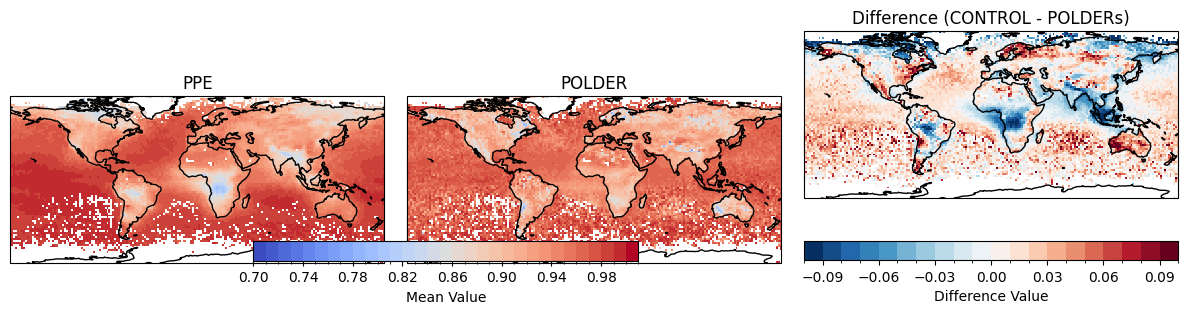

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
clevs_aod = np.arange(0, 0.5 + 0.05, 0.05)
clevs_ang=np.arange(0,2+0.2,0.2)
clevs_ssa=np.arange(0.7,1+0.01,0.01)
clevs_diff_aod = np.arange(-0.5, 0.5 + 0.1, 0.05)
clevs_diff_ssa = np.arange(-0.1, 0.1 + 0.01, 0.01)
clevs_diff_ang = np.arange(-0.5, 0.5 + 0.1, 0.05)

# Compute the mean over ensemble and time
mean_data1 = SSA_GLOBAL[:, 0].mean(dim=["time"])  # First mean dataset
mean_data2 = SSA_GLOBAL[:, -1].mean(dim=["time"])               # Second mean dataset
diff_data = mean_data1 - mean_data2

# Mask mean_data1 to have NaN values where mean_data2 is NaN
mean_data1 = mean_data1.where(~np.isnan(mean_data2))


# Define norm using contour levels
norm = mcolors.BoundaryNorm(clevs_ssa, ncolors=plt.get_cmap("coolwarm").N, clip=True)
diff_norm = mcolors.BoundaryNorm(clevs_diff_ssa, ncolors=plt.get_cmap("coolwarm").N, clip=True)

# Create figure and axes
fig, axes = plt.subplots(1, 3, figsize=(12, 5), subplot_kw={"projection": ccrs.PlateCarree()})

# First plot
p1 = axes[0].pcolormesh(mean_data1.lon, mean_data1.lat, mean_data1, 
                         transform=ccrs.PlateCarree(), cmap="coolwarm", norm=norm)
axes[0].set_title("PPE")
axes[0].coastlines()

# Second plot
p2 = axes[1].pcolormesh(mean_data2.lon, mean_data2.lat, mean_data2, 
                         transform=ccrs.PlateCarree(), cmap="coolwarm", norm=norm)
axes[1].set_title("POLDER")
axes[1].coastlines()

# Third plot: Difference (Mean Data 1 - Mean Data 2)
p3 = axes[2].pcolormesh(mean_data1.lon, mean_data1.lat, diff_data, 
                         transform=ccrs.PlateCarree(), cmap="RdBu_r", norm=diff_norm)
axes[2].set_title("Difference (CONTROL - POLDER)")
axes[2].coastlines()

# Add colorbars
cbar1 = fig.colorbar(p1, ax=axes[:2], orientation="horizontal", fraction=0.05, pad=0.1)
cbar1.set_label("Mean Value")

cbar2 = fig.colorbar(p3, ax=axes[2], orientation="horizontal", fraction=0.05, pad=0.1)
cbar2.set_label("Difference Value")

plt.tight_layout()
plt.show()



In [197]:
# ## This is to get an array of: xarray.DataArray month: 12 lat: 161 lon: 358. For POLDER and the PPE.

# # This is important data process. Save manually below.

# #SSA_land_polder = process_POLDER_data(SSA_LAND[:,:,-1])
# SSA_land_PPE = process_POLDER_data(SSA_LAND[:,:,:])
# #SSA_ocean_polder = process_POLDER_data(SSA_OCEAN[:,:,-1])
# SSA_ocean_PPE = process_POLDER_data(SSA_OCEAN[:,:,:])

# #AOD_land_polder = process_POLDER_data(AOD_LAND[:,:,-1])
# AOD_land_PPE = process_POLDER_data(AOD_LAND[:,:,:])
# #AOD_ocean_polder = process_POLDER_data(AOD_OCEAN[:,:,-1])
# AOD_ocean_PPE = process_POLDER_data(AOD_OCEAN[:,:,:])

# #ANG_land_polder = process_POLDER_data(ANG_LAND[:,:,-1])
# ANG_land_PPE = process_POLDER_data(ANG_LAND[:,:,:])
# #ANG_ocean_polder = process_POLDER_data(ANG_OCEAN[:,:,-1])
# ANG_ocean_PPE = process_POLDER_data(ANG_OCEAN[:,:,:])


# # SSA_Polder = regrid_and_combine(
# #     SSA_land_polder, SSA_ocean_polder
# # )
# SSA_PPE = regrid_and_combine(
#     SSA_land_PPE, SSA_ocean_PPE
# )
# AOD_PPE = regrid_and_combine(
#     AOD_land_PPE, AOD_ocean_PPE
# )
# # AOD_Polder = regrid_and_combine(
# #     AOD_land_polder, AOD_ocean_polder
# # )
# ANG_PPE = regrid_and_combine(
#     ANG_land_PPE, ANG_ocean_PPE
# )
# # ANG_Polder = regrid_and_combine(
# #     ANG_land_polder, ANG_ocean_polder
# # )


# ANG_PPE.to_netcdf('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/2009/ANG_PPE_Pre_Emulator.nc')
# AOD_PPE.to_netcdf('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/2009/AOD_PPE_Pre_Emulator.nc')
# SSA_PPE.to_netcdf('/home/ybhatti/prjs1076/Processed_Data/PD/Observational_Comparison/Processed/POLDER/2009/SSA_PPE_Pre_Emulator.nc')


In [9]:
# import scipy.interpolate

# # Define target grid
# lat_bins = np.linspace(SSA.lat.min(), SSA.lat.max(), num=180)  # Adjust resolution
# lon_bins = np.linspace(SSA.lon.min(), SSA.lon.max(), num=360)

# # Create a new dataset with regular lat-lon bins
# lat_grid, lon_grid = np.meshgrid(lat_bins, lon_bins)

# # Prepare an empty list to store interpolated results
# ssa_interp_list = []

# # Loop over each day
# for day_idx in range(SSA.sizes["day"]):
#     ens_interp_list = []  # Store interpolations for each ensemble at this day
    
#     for ens_idx in range(SSA.sizes["ensemble"]):
#         # Extract SSA, lat, and lon for the current day and ensemble
#         ssa_ens = SSA.isel(day=day_idx, ensemble=ens_idx).values.flatten()
#         lat_day = SSA.lat.isel(day=day_idx).values.flatten()
#         lon_day = SSA.lon.isel(day=day_idx).values.flatten()
    
#         # Remove NaNs for interpolation
#         mask = ~np.isnan(lat_day) & ~np.isnan(lon_day) & ~np.isnan(ssa_ens)
#         lat_day, lon_day, ssa_ens = lat_day[mask], lon_day[mask], ssa_ens[mask]
    
#         # Perform interpolation
#         ssa_interp = scipy.interpolate.griddata(
#             (lat_day, lon_day), ssa_ens, (lat_grid, lon_grid), method="linear"
#         )
        
#         ens_interp_list.append(ssa_interp)  # Store for this ensemble
    
#     ssa_interp_list.append(ens_interp_list)  # Store all ensembles for this day
#     if day_idx == 11:
#         end
# # Convert list to numpy array and reshape
# ssa_interp_array = np.array(ssa_interp_list)  # Shape: (day, ensemble, lat, lon)

# # Convert to xarray DataArray
# ssa_interp_xr = xr.DataArray(
#     ssa_interp_array.transpose(0, 1, 3, 2),  # Swap lat and lon
#     coords={"day": SSA.day[0], "ensemble": SSA.ensemble, "lat": lat_bins, "lon": lon_bins},
#     dims=["day", "ensemble", "lat", "lon"],  # Corrected dimension order
# )


NameError: name 'end' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
model_spatial_mean = model_ensemble.mean(dim='day')#.isel(day=0)
obs_spatial = SSA.sel(ensemble=-1).mean(dim='day')#.isel(day=0)  # example for a specific day
Lat_for_plot = SSA.sel(ensemble=-1).isel(day=0)  # example for a specific day

# Remove NaNs before interpolation
valid_mask = ~np.isnan(obs_spatial)
obs_lon = SSA['lon'][valid_mask]
obs_lat = SSA['lat'][valid_mask]
obs_values = obs_spatial[valid_mask]
model_values = model_spatial_mean[valid_mask]

# Define target grid
lon_bins = np.linspace(obs_lon.min(), obs_lon.max(), num=192)  # Adjust resolution
lat_bins = np.linspace(obs_lat.min(), obs_lat.max(), num=96)

# Create 2D histogram for binning
obs_2d, _, _ = np.histogram2d(obs_lat, obs_lon, bins=[lat_bins, lon_bins], weights=obs_values)
obs_counts, _, _ = np.histogram2d(obs_lat, obs_lon, bins=[lat_bins, lon_bins])
# Normalize by counts to get mean values in each grid cell
obs_2d /= np.maximum(obs_counts, 1)  # Avoid division by zero
# Convert to xarray DataArray
obs_spatial_2d = xr.DataArray(obs_2d, coords=[lat_bins[:-1], lon_bins[:-1]], dims=["lat", "lon"])

# Create 2D histogram for binning
model_2d, _, _ = np.histogram2d(obs_lat, obs_lon, bins=[lat_bins, lon_bins], weights=model_values)
model_counts, _, _ = np.histogram2d(obs_lat, obs_lon, bins=[lat_bins, lon_bins])
# Normalize by counts to get mean values in each grid cell
model_2d /= np.maximum(model_counts, 1)  # Avoid division by zero
# Convert to xarray DataArray
model_spatial_2d = xr.DataArray(model_2d, coords=[lat_bins[:-1], lon_bins[:-1]], dims=["lat", "lon"])


fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# Plot observation
axes[0].coastlines()
axes[0].contourf(obs_spatial_2d['lon'], obs_spatial_2d['lat'], obs_spatial_2d, cmap='viridis')
axes[0].set_title('Observational SSA')

# Plot model ensemble mean
axes[1].coastlines()
axes[1].contourf(model_spatial_2d['lon'], model_spatial_2d['lat'], model_spatial_2d, cmap='viridis')
axes[1].set_title('Model Ensemble Mean SSA')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
model_spatial_mean = ssa_interp_xr[:,:-1].mean(dim=['day','ensemble'])#.isel(day=0)
obs_spatial = ssa_interp_xr[:,-1].mean(dim='day')#.isel(day=0)  # example for a specific day
#Lat_for_plot = SSA.sel(ensemble=-1).isel(day=0)  # example for a specific day


fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# Plot observation
axes[0].coastlines()
axes[0].contourf(obs_spatial['lon'], obs_spatial['lat'], obs_spatial, cmap='viridis')
axes[0].set_title('Observational SSA')

# Plot model ensemble mean
axes[1].coastlines()
axes[1].contourf(model_spatial_mean['lon'], model_spatial_mean['lat'], model_spatial_mean, cmap='viridis')
axes[1].set_title('Model Ensemble Mean SSA')

plt.show()


In [6]:
# flat_obv = SSA[:,:-1].mean(dim=['day','ensemble']).data.flatten()  # excluding last column
# obs_spatial = SSA[:,-1].mean(dim=['day']).data.flatten()  # Mean across 'day'

PPE_SSA = SSA[:,:,-1].mean('day').data.flatten()
PPE_SSA_Obs = SSA[:,:,:-1].mean('day').data.flatten()

PPE_ANG = ANG[:,:,-1].mean('day').data.flatten()
PPE_ANG_Obs = ANG[:,:,:-1].mean('day').data.flatten()

PPE_AOD = AOD[:,:,-1].mean('day').data.flatten()
PPE_AOD_Obs = AOD[:,:,:-1].mean('day').data.flatten()

PPE_SSA_OCEAN = SSA_OCEAN[:,:,-1].mean('day').data.flatten()
PPE_SSA_Obs_OCEAN = SSA_OCEAN[:,:,:-1].mean('day').data.flatten()

PPE_ANG_OCEAN = ANG_OCEAN[:,:,-1].mean('day').data.flatten()
PPE_ANG_Obs_OCEAN = ANG_OCEAN[:,:,:-1].mean('day').data.flatten()

PPE_AOD_OCEAN = AOD_OCEAN[:,:,-1].mean('day').data.flatten()
PPE_AOD_Obs_OCEAN = AOD_OCEAN[:,:,:-1].mean('day').data.flatten()


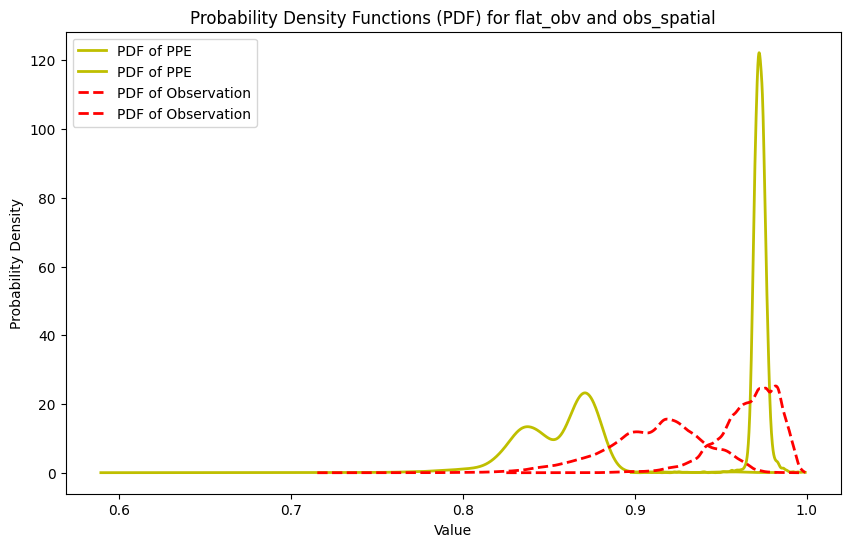

In [37]:
import scipy.stats as stats

def PDF_For_POLDER(Flat_Data_PPE,Flat_Obs):
    # Remove NaNs if any
    flat_obv = Flat_Data_PPE[~np.isnan(Flat_Data_PPE)]
    obs_spatial = Flat_Obs[~np.isnan(Flat_Obs)]
    
    # Kernel Density Estimate (KDE) for the PDF of flat_obv
    kde_flat_obv = stats.gaussian_kde(flat_obv, bw_method='scott')  # Bandwidth 'scott' or 'silverman'
    
    # KDE for the PDF of obs_spatial
    kde_obs_spatial = stats.gaussian_kde(obs_spatial, bw_method='scott')
    
    # Generate a range of values for plotting the PDFs
    x_flat_obv = np.linspace(np.min(flat_obv), np.max(flat_obv), 1000)
    x_obs_spatial = np.linspace(np.min(obs_spatial), np.max(obs_spatial), 1000)
    
    # Evaluate the KDE over the range
    pdf_flat_obv = kde_flat_obv(x_flat_obv)
    pdf_obs_spatial = kde_obs_spatial(x_obs_spatial)
    return x_flat_obv, pdf_flat_obv, x_obs_spatial, pdf_obs_spatial
SSA_Land = PDF_For_POLDER(PPE_AOD,PPE_AOD_Obs)
SSA_Ocean = PDF_For_POLDER(PPE_AOD_OCEAN,PPE_AOD_Obs_OCEAN)

# Plotting the PDFs
plt.figure(figsize=(10, 6))

# Plot flat_obv PDF
plt.plot(SSA_Land[0], SSA_Land[1], label='PDF of PPE', color='y', linestyle='-', linewidth=2)
plt.plot(SSA_Ocean[0], SSA_Ocean[1], label='PDF of PPE', color='y', linestyle=':', linewidth=2)

# Plot obs_spatial PDF
plt.plot(SSA_Land[2], SSA_Land[3], label='PDF of Observation', color='red', linestyle='--', linewidth=2)
plt.plot(SSA_Ocean[2], SSA_Ocean[3], label='PDF of Observation', color='red', linestyle='-.', linewidth=2)

# Labels and title
plt.title('Probability Density Functions (PDF) for flat_obv and obs_spatial')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()


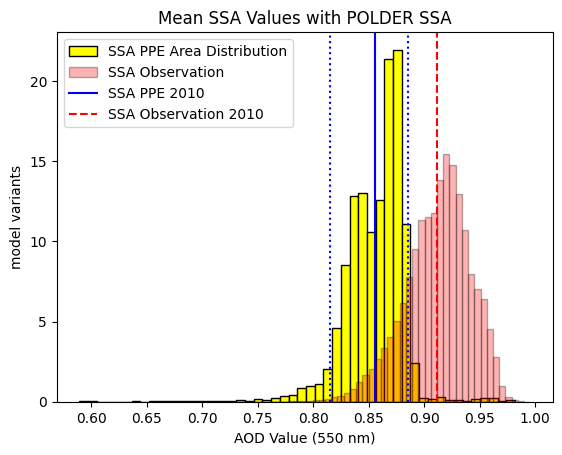

In [21]:

#plt.plot(AOD_PPE_area, color='yellow')

# Normalize histograms with density=True
plt.hist(flat_obv, bins=50, color='yellow', edgecolor='black', alpha=1, label='SSA PPE Area Distribution', density=True)
plt.hist(obs_spatial, bins=50, color='red', edgecolor='black', alpha=0.3, label='SSA Observation', density=True)

plt.axvline(flat_obv.mean(), color='blue', linestyle='-',label='SSA PPE 2010')
plt.axvline(obs_spatial.mean(), color='red', linestyle='--',label='SSA Observation 2010')

plt.axvline(np.nanpercentile(flat_obv,95), color='blue', linestyle=':')
plt.axvline(np.nanpercentile(flat_obv,5), color='blue', linestyle=':')

plt.title('Mean SSA Values with POLDER SSA')

plt.ylabel('model variants')
plt.xlabel('AOD Value (550 nm)')
plt.legend()

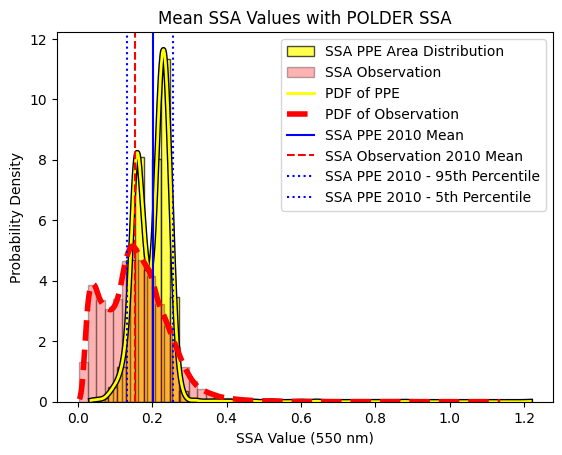

In [22]:
import matplotlib.pyplot as plt
import numpy as np
# Remove NaNs if any
flat_obv = PPE_AOD[~np.isnan(PPE_AOD)]
obs_spatial = PPE_AOD_Obs[~np.isnan(PPE_AOD_Obs)]
ANG_Land = PDF_For_POLDER(PPE_AOD,PPE_AOD_Obs)

# Plot histograms with density=True
plt.hist(PPE_AOD, bins=50, color='yellow', edgecolor='black', alpha=0.7, label='SSA PPE Area Distribution', density=True)
plt.hist(PPE_AOD_Obs, bins=50, color='red', edgecolor='black', alpha=0.3, label='SSA Observation', density=True)

# Plot the PDF lines with yellow color and black outline
# Plot the black outline first (slightly thicker)
plt.plot(ANG_Land[0], ANG_Land[1], color='black', linestyle='-', linewidth=4)

# Plot the yellow line on top of the black outline
plt.plot(ANG_Land[0], ANG_Land[1], label='PDF of PPE', color='yellow', linestyle='-', linewidth=2)

# Plot the other PDF line for obs_spatial
plt.plot(ANG_Land[2], ANG_Land[3], label='PDF of Observation', color='red', linestyle='--', linewidth=4)

# Add vertical lines for the mean and percentiles
plt.axvline(flat_obv.mean(), color='blue', linestyle='-', label='SSA PPE 2010 Mean')
plt.axvline(obs_spatial.mean(), color='red', linestyle='--', label='SSA Observation 2010 Mean')

plt.axvline(np.nanpercentile(flat_obv, 95), color='blue', linestyle=':', label='SSA PPE 2010 - 95th Percentile')
plt.axvline(np.nanpercentile(flat_obv, 5), color='blue', linestyle=':', label='SSA PPE 2010 - 5th Percentile')

# Set title and labels
plt.title('Mean SSA Values with POLDER SSA')
plt.xlabel('SSA Value (550 nm)')
plt.ylabel('Probability Density')

# Display legend
plt.legend()

# Show the plot
plt.show()


In [87]:
# ### FOR POLDER
# da = SSA_LAND[:,:,-1]
# # Flatten overpass dimension
# da_flat = da.stack(sample=("day", "overpass"))
# # Drop NaT values in time
# da_flat = da_flat.sel(sample=~xr.ufuncs.isnan(da_flat["time"]))
# # Group by month
# grouped_da = da_flat.groupby(da_flat["time"].dt.month)


In [ ]:
# monthly_data = []
# for month in range(1, 13):  # Loop through months 1 to 12
#     # Select data for the current month
#     monthly_da = grouped_da[month]
    
#     # Extract the month from the 'time' coordinate (if not already done)
#     monthly_da['month'] = monthly_da['time'].dt.month
    
#     # Group by 'lat' and 'lon' (assuming 'month' is already in the coordinate)
#     grouped = monthly_da.groupby(['lat', 'lon']).mean()
    
#     # Reshape to the desired (lat, lon) structure, adding the 'month' dimension
#     reshaped = grouped.transpose('lat', 'lon')
    
#     # Store the reshaped data
#     monthly_data.append(reshaped)

# # Now monthly_data holds the reshaped DataArray for each month



# # Step 1: Find the global min/max latitudes and longitudes
# all_lats = []
# all_lons = []

# for data in monthly_data:
#     all_lats.extend(data.lat.values)
#     all_lons.extend(data.lon.values)

# min_lat, max_lat = min(all_lats), max(all_lats)
# min_lon, max_lon = min(all_lons), max(all_lons)

# # Step 2: Create a new common lat/lon grid covering all the data
# new_lats = np.arange(min_lat, max_lat, 1)  # You can adjust the step size
# new_lons = np.arange(min_lon, max_lon, 1)  # Adjust the step size here as well

# # Step 3: Regrid each month's data to this new grid
# aligned_data = []
# for data in monthly_data:
#     aligned_data.append(data.interp(lat=new_lats, lon=new_lons))

# # Step 4: Combine all the months into a single DataArray along the 'month' dimension
# SSA_LAND_combined_da_PPE = xr.concat(aligned_data, dim='month')


In [ ]:
# ### FOR PPE ####

# import xarray as xr
# import numpy as np

# # Assuming `SSA_LAND` is your input DataArray
# da = SSA_LAND[:, :, :-1]  # Exclude the last ensemble member if needed

# # Flatten the overpass dimension
# da_flat = da.stack(sample=("day", "overpass"))

# # Drop NaT values in time
# da_flat = da_flat.sel(sample=~xr.ufuncs.isnan(da_flat["time"]))

# # Group by month
# grouped_da = da_flat.groupby(da_flat["time"].dt.month)

# # Initialize a list to store monthly data
# monthly_data = []

# # Loop through months 1 to 12
# for month in range(1, 13):
#     # Select data for the current month
#     monthly_da = grouped_da[month]
    
#     # Extract the month from the 'time' coordinate
#     monthly_da['month'] = monthly_da['time'].dt.month
    
#     # Group by 'lat' and 'lon' and compute the mean
#     grouped = monthly_da.groupby(['lat', 'lon']).mean()
    
#     # Unstack the grouped data to restore 'lat' and 'lon' as dimensions
#  #   reshaped = grouped.unstack('sample')
    
#     # Store the reshaped data
#     monthly_data.append(reshaped)

# # Step 1: Find the global min/max latitudes and longitudes
# all_lats = np.concatenate([data.lat.values for data in monthly_data if 'lat' in data.dims])
# all_lons = np.concatenate([data.lon.values for data in monthly_data if 'lon' in data.dims])

# min_lat, max_lat = np.nanmin(all_lats), np.nanmax(all_lats)
# min_lon, max_lon = np.nanmin(all_lons), np.nanmax(all_lons)

# # Step 2: Create a new common lat/lon grid covering all the data
# new_lats = np.arange(min_lat, max_lat, 1)  # Adjust the step size as needed
# new_lons = np.arange(min_lon, max_lon, 1)  # Adjust the step size as needed

# # Step 3: Regrid each month's data to this new grid
# aligned_data = []
# for data in monthly_data:
#     # Ensure the DataArray has 'lat' and 'lon' dimensions
#     if 'lat' in data.dims and 'lon' in data.dims:
#         aligned_data.append(data.interp(lat=new_lats, lon=new_lons))

# # Step 4: Combine all the months into a single DataArray along the 'month' dimension
# SSA_LAND_combined_da_PPE = xr.concat(aligned_data, dim='month')

# # Print the final combined DataArray
# print(SSA_LAND_combined_da_PPE)

In [154]:
SSA_land_polder = process_POLDER_data(SSA_LAND[:,:,-1])
SSA_land_PPE = process_POLDER_data(SSA_LAND[:,:,:-1])
SSA_ocean_polder = process_POLDER_data(SSA_OCEAN[:,:,-1])
SSA_ocean_PPE = process_POLDER_data(SSA_OCEAN[:,:,:-1])

AOD_land_polder = process_POLDER_data(AOD_LAND[:,:,-1])
AOD_land_PPE = process_POLDER_data(AOD_LAND[:,:,:-1])
AOD_ocean_polder = process_POLDER_data(AOD_OCEAN[:,:,-1])
AOD_ocean_PPE = process_POLDER_data(AOD_OCEAN[:,:,:-1])

ANG_land_polder = process_POLDER_data(ANG_LAND[:,:,-1])
ANG_land_PPE = process_POLDER_data(ANG_LAND[:,:,:-1])
ANG_ocean_polder = process_POLDER_data(ANG_OCEAN[:,:,-1])
ANG_ocean_PPE = process_POLDER_data(ANG_OCEAN[:,:,:-1])

In [ ]:
# # Step 1: Create a new combined grid (union of latitudes and longitudes)
# all_lats = np.concatenate([SSA_land_PPE.lat.values, SSA_ocean_PPE.lat.values])
# all_lons = np.concatenate([SSA_land_PPE.lon.values, SSA_ocean_PPE.lon.values])

# min_lat, max_lat = np.min(all_lats), np.max(all_lats)
# min_lon, max_lon = np.min(all_lons), np.max(all_lons)

# # Create new lat/lon grid
# new_lats = np.arange(min_lat, max_lat, 1)  # Adjust step size as needed
# new_lons = np.arange(min_lon, max_lon, 1)  # Adjust step size as needed

# # Step 2: Regrid both datasets onto the new grid
# land_aligned = SSA_land_PPE.interp(lat=new_lats, lon=new_lons)
# ocean_aligned = SSA_ocean_PPE.interp(lat=new_lats, lon=new_lons)

# # Step 3: Initialize the combined array (filling NaNs initially)
# combined_da = xr.DataArray(np.full_like(land_aligned.values, np.nan), 
#                            coords={'lat': new_lats, 'lon': new_lons, 'month': SSA_land_PPE.month, 'ensemble': SSA_land_PPE.ensemble},
#                            dims=['month','ensemble', 'lat', 'lon'])

# # Step 4: Fill in land and ocean data
# combined_da = combined_da.where(np.isnan(land_aligned), land_aligned)  # Land data where valid
# combined_da = combined_da.where(np.isnan(ocean_aligned), ocean_aligned)  # Ocean data where valid
